# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.8 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### Add in DDPG algorithm for the agent to learn

In [5]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc_layers=[400,300]):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc_layers (list): Number of nodes in hidden layers
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        # Define input and output values for the hidden layers
        dims = [state_size] + fc_layers + [action_size]
        # Create the hidden layers
        self.fc_layers = nn.ModuleList(
            [nn.Linear(dim_in, dim_out) for dim_in, dim_out in zip(dims[:-1], dims[1:])])

        # Initialize the hidden layer weights
        self.reset_parameters()

        print('Actor network built:', self.fc_layers)



    def reset_parameters(self):
        for layer in self.fc_layers[:-1]:
            layer.weight.data.uniform_(*hidden_init(layer) )
        self.fc_layers[-1].weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, x):
        """Build an actor (policy) network that maps states -> actions.
        Params
        ======
            x (state shape): state passed to the network
        """
        # Pass the input through all the layers apllying ReLU activation, but the last
        for layer in self.fc_layers[:-1]:
            x = F.relu(layer(x))
        # Pass the result through the output layer apllying hyperbolic tangent function
        return F.tanh(self.fc_layers[-1](x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fc_layers=[400,300]):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc_layers (list): Number of nodes in hidden layers
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)

        #hidden layers+ output layer (which is size of 1 , critic's estimation of desicion took)
        dims = fc_layers + [1]
        # Create a list of layers
        layers_list = []

        layers_list.append(nn.Linear(state_size, dims[0]))

        # The second layer receives the the first layer output + action
        layers_list.append(nn.Linear(dims[0] + action_size, dims[1]))

        # Build the next layers, if that is the case
        for dim_in, dim_out in zip(dims[1:-1], dims[2:]):
            layers_list.append(nn.Linear(dim_in, dim_out))

        # Store the layers as a ModuleList
        self.fc_layers = nn.ModuleList(layers_list)
        # Initialize the hidden layer weights
        self.reset_parameters()
        # Add batch normalization to the first hidden layer
        self.bn = nn.BatchNorm1d(dims[0])
        print('Critic network built:', self.fc_layers)

    def reset_parameters(self):
        for layer in self.fc_layers[:-1]:
            layer.weight.data.uniform_(*hidden_init(layer) )
        self.fc_layers[-1].weight.data.uniform_(-3e-3, 3e-3)


    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        #x_state = F.leaky_relu(self.fc_layers[0](state))
        #x_state = F.relu(self.fc_layers[0](state))
        x_state = F.relu(self.fc_layers[0](state))
        # Concatenate the first layer output with the action
        x = torch.cat((x_state, action), dim=1)
        # Pass the input through all the layers applying ReLU activation, but the last
        for layer in self.fc_layers[1:-1]:
            x = F.relu(layer(x))
        # Pass the result through the output layer  sigmoid activation
        x = torch.sigmoid(self.fc_layers[-1](x))
        # Return the Q-Value for the input state-action
        return x

In [6]:
import numpy as np
import random
import copy
from collections import namedtuple, deque

# from model import Actor, Critic

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0.0001   # L2 weight decay
NOISE_DECAY = 0.999     # noise decay
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device : ",device)
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        print('DDPG Agent hyperparameters:\n\t' \
              'batch size: \t\t{:8.0f}\n\t' \
              'buffer size: \t\t{:8.0f}\n\t' \
              'discount / gamma: \t{:8.3f}\n\t' \
              'actor learning rate: \t{:8.3f}\n\t' \
              'critic learning rate: \t{:8.3f}\n\t' \
              'soft update / tau: \t{:8.3f}\n\t' \
              'noise decay rate: \t{:8.3f}\n\t' #\
              #'Weight decay rate: \t{:8.3f}\n'
              .format(BUFFER_SIZE, BUFFER_SIZE, GAMMA,
                      LR_ACTOR, LR_CRITIC, TAU, NOISE_DECAY))#, WEIGHT_DECAY))

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC)#, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)
        self.noise_decay = NOISE_DECAY

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample() * self.noise_decay
            self.noise_decay *= self.noise_decay
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


Using device :  cuda:0


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [7]:
agents=[]
for agent in range(0,num_agents): 
   agents.append(Agent(state_size=brain.vector_observation_space_size, action_size=brain.vector_action_space_size, random_seed=10))

DDPG Agent hyperparameters:
	batch size: 		 1000000
	buffer size: 		 1000000
	discount / gamma: 	   0.990
	actor learning rate: 	   0.001
	critic learning rate: 	   0.001
	soft update / tau: 	   0.001
	noise decay rate: 	   0.999
	
Actor network built: ModuleList(
  (0): Linear(in_features=33, out_features=400, bias=True)
  (1): Linear(in_features=400, out_features=300, bias=True)
  (2): Linear(in_features=300, out_features=4, bias=True)
)
Actor network built: ModuleList(
  (0): Linear(in_features=33, out_features=400, bias=True)
  (1): Linear(in_features=400, out_features=300, bias=True)
  (2): Linear(in_features=300, out_features=4, bias=True)
)
Critic network built: ModuleList(
  (0): Linear(in_features=33, out_features=400, bias=True)
  (1): Linear(in_features=404, out_features=300, bias=True)
  (2): Linear(in_features=300, out_features=1, bias=True)
)
Critic network built: ModuleList(
  (0): Linear(in_features=33, out_features=400, bias=True)
  (1): Linear(in_features=404, out_fea

In [8]:
def ddpg(n_episodes=2000, max_t=1000):
    episode_scores_deque = deque(maxlen=100)
    episode_scores = []     
    max_score = -np.Inf
        
    for i_episode in range(1, n_episodes+1):
        env_info = env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)   
        for agent in agents:  agent.reset() #agent.reset() #for agent in agents:  agent.reset()
        
        for t in range(max_t):
            actions=[]
            for i in range(num_agents): 
                actions.append(agents[i].act(states[i]))  # select an action (for each agent)
            env_info = env.step(actions)[brain_name]                    # send all actions to tne environment
            next_states = env_info.vector_observations                  # get next state (for each agent)
            rewards = env_info.rewards                                  # get reward (for each agent)
            dones = env_info.local_done                                 # see if episode finished
            agent.step(states, actions, rewards, next_states, dones)    # update weights (for each agent)
            scores += env_info.rewards                                  # update the score (for each agent)
            states = next_states                                        # roll over states to next time step
            
            if np.any(dones):                                           # exit loop if episode finished
                break
        episode_scores_deque.append(np.mean(scores))            # append the avg score by agents in this eposide
        episode_scores.append(np.mean(scores))                  # append the avg score by agents in this eposide
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(episode_scores_deque), np.mean(scores)), end="")
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_without_batchnormalization.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_without_batchnormalization.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(episode_scores_deque)))
        if np.mean(episode_scores_deque) >= 30.0 :
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(episode_scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_without_batchnormalization.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_without_batchnormalization.pth')
            break
    return episode_scores

scores = ddpg() #(n_episodes=1,max_t=20)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 100	Average Score: 3.64	Score: 4.74
Episode 200	Average Score: 6.87	Score: 10.13
Episode 300	Average Score: 10.56	Score: 8.560
Episode 400	Average Score: 11.80	Score: 6.950
Episode 500	Average Score: 14.36	Score: 9.361
Episode 600	Average Score: 16.75	Score: 19.72
Episode 700	Average Score: 20.08	Score: 27.46
Episode 800	Average Score: 24.17	Score: 30.76
Episode 900	Average Score: 24.92	Score: 22.92
Episode 1000	Average Score: 28.90	Score: 20.90
Episode 1088	Average Score: 30.00	Score: 32.57
Environment solved in 1088 episodes!	Average Score: 30.00


NameError: name 'plt' is not defined

Text(0.5,0,'Episode #')

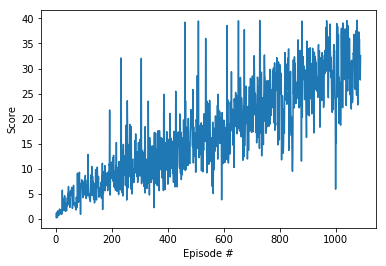

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')


In [ ]:
# env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
# states = env_info.vector_observations                  # get the current state (for each agent)
# scores = np.zeros(1)                          # initialize the score (for each agent)
# episodes = 10000
# robotic_arm_hist = np.array([])
# robotic_arm_reward = deque(maxlen=100)
# time = 1050

# agent = Agent(state_size,action_size,random_seed=0)   
# for episode in range(episodes):
#     env_info = env.reset(train_mode=True)[brain_name]      # reset the environment 
#     cur_state = env_info.vector_observations[0]
#     scores = 0                          # initialize the score (for each agent)
#     agent.reset()
#     for time_t in range(time+1):
#         # Predict the best action for the current state. 
#         action = agent.act(cur_state, add_noise = True)
#         # Action is performed and new state, reward, info are received. 
#         env_info = env.step(action)[brain_name]
#         next_state = env_info.vector_observations[0]
#         dones = env_info.local_done[0]
#         rewards = env_info.rewards[0]
#         # current state, action, reward, new state are stored in the experience replay
#         agent.step(cur_state, action, rewards, next_state, dones)
#         scores += rewards                         # update the score (for each agent)
#         cur_state = next_state                               # roll over states to next time step
#         if dones:
#             print("Time : {} and Rewards: {}".format(time_t,scores))
#             break;

#     robotic_arm_reward.append(scores)
#     if np.mean(robotic_arm_reward) >= 30:
#         print(" Done !! ")
#         break
        
#     if (episode + 1) % 100 == 0: # print average shortfall over last 100 episodes
#         print('\rEpisode [{}/{}]\Robotics arm rewards: ${:,.2f}'.format(episode + 1, episodes, np.mean(robotic_arm_reward)))   
# # roll over new state
# #         actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
# #         actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
# #         env_info = env.step(actions)[brain_name]           # send all actions to tne environment
# #         next_states = env_info.vector_observations         # get next state (for each agent)
# #         rewards = env_info.rewards                         # get reward (for each agent)
# #         dones = env_info.local_done                        # see if episode finished

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [ ]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt
import argparse

from agent import Agent

def ddpg(n_episodes=2000, max_t=1000,
        target=100.0, actor_model='checkpoint_actor.pth', critic_model='checkpoint_critic.pth'):
    """Deep Deterministic Policy Gradients.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        target (float): desired minimal average per 100 episodes
        actor_model (str): path to save actor model
        critic_model (str): path to save critic model
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]
        agent.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished

            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= target:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), actor_model)
            torch.save(agent.critic_local.state_dict(), critic_model)
            break
    return scores

if __name__ == '__main__':
#     parser = argparse.ArgumentParser()

#     parser.add_argument('--environment', type=str, help='Path to Unity environment files',
#                         default='Reacher_Linux_NoVis/Reacher.x86_64')
#     parser.add_argument('--actor_model', type=str, help='Path to save actor model',
#                         default='checkpoint_actor.pth')
#     parser.add_argument('--critic_model', type=str, help='Path to save critic model',
#                         default='checkpoint_critic.pth')
#     parser.add_argument('--buffer', type=str, help='Replay buffer type - sample or prioritized',
#                         default='prioritized')
#     parser.add_argument('--episodes', type=int, help='Maximum number of training episodes',
#                         default=2000)
#     parser.add_argument('--frames', type=int, help='Maximum number of frames in training episode',
#                         default=1000)
#     parser.add_argument('--target', type=float, help='Desired minimal average per 100 episodes',
#                         default=30.0)
#     parser.add_argument('--buffer_size', type=int, help='Replay buffer size',
#                         default=1000000)
#     parser.add_argument('--batch_size', type=int, help='Minibatch size',
#                         default=1024)
#     parser.add_argument('--gamma', type=float, help='Discount factor',
#                         default=0.85)
#     parser.add_argument('--tau', type=float, help='For soft update of target parameters',
#                         default=0.001)
#     parser.add_argument('--alpha', type=float, help='Prioritized buffer - How much prioritization is used (0 - no prioritization, 1 - full prioritization)',
#                         default=0.5)
#     parser.add_argument('--beta', type=float, help='Prioritized buffer - To what degree to use importance weights (0 - no corrections, 1 - full correction)',
#                     default=0.5)
#     parser.add_argument('--actor_learning_rate', type=float, help='Actor learning rate',
#                         default=0.0005)
#     parser.add_argument('--critic_learning_rate', type=float, help='Critic learning rate',
#                         default=0.0005)
#     parser.add_argument('--cuda', dest='cuda', action='store_true')
#     parser.add_argument('--no_cuda', dest='cuda', action='store_false')
#     parser.set_defaults(cuda=True)

    print('Training')
#     args = parser.parse_args()

    env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

    # get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    print(brain_name)
    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name]

    # initialize agent
    action_size = brain.vector_action_space_size
    state = env_info.vector_observations[0]
    state_size = len(state)
    agent = Agent(state_size=state_size, action_size=action_size, seed=0,
                  training=True)

    scores = ddpg(n_episodes=2000, max_t=1000, target=100,actor_model='checkpoint_actor.pth', critic_model='checkpoint_critic.pth')

    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.savefig('checkpoint_actor.pth' + '.png')

    env.close()

Training


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


ReacherBrain
Episode 15	Average Score: 0.59

In [7]:
# import numpy as np

# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# def hidden_init(layer):
#     fan_in = layer.weight.data.size()[0]
#     lim = 1. / np.sqrt(fan_in)
#     return (-lim, lim)


# def _reset_parameters(layers):
#     for layer in layers:
#         layer.weight.data.uniform_(-3e-3,3e-3)
        

# class Actor(nn.Module):
#     """Actor (Policy) Model."""

#     def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=128):
#         """Initialize parameters and build model.
#         Params
#         ======
#             state_size (int): Dimension of each state
#             action_size (int): Dimension of each action
#             seed (int): Random seed
#             fc1_units (int): Number of nodes in first hidden layer
#             fc2_units (int): Number of nodes in second hidden layer
#         """
#         super(Actor, self).__init__()
#         self.seed = torch.manual_seed(seed)
#         self.fc1 = nn.Linear(state_size, fc1_units) # 33 x 24
#         self.fc2 = nn.Linear(fc1_units, fc2_units) # 24 x 48
#         self.fc3 = nn.Linear(fc2_units, action_size) # 48 x 4
#         self.reset_parameters()

#     def reset_parameters(self):
# #         self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
#         self.fc1.weight.data.uniform_(-3e-3, 3e-3)
#         self.fc2.weight.data.uniform_(-3e-3, 3e-3)
#         self.fc3.weight.data.uniform_(-3e-3, 3e-3)

#     def forward(self, state):
#         """Build an actor (policy) network that maps states -> actions."""
#         x = F.relu(self.fc1(state))
#         x = F.relu(self.fc2(x))
#         return F.tanh(self.fc3(x))


# class Critic(nn.Module):
#     """Critic (Value) Model."""

#     def __init__(self, state_size, action_size, seed, fcs1_units=128, fc2_units=128):
#         """Initialize parameters and build model.
#         Params
#         ======
#             state_size (int): Dimension of each state
#             action_size (int): Dimension of each action
#             seed (int): Random seed
#             fcs1_units (int): Number of nodes in the first hidden layer
#             fc2_units (int): Number of nodes in the second hidden layer
#         """
#         super(Critic, self).__init__()
#         self.seed = torch.manual_seed(seed)
#         self.fcs1 = nn.Linear(state_size, fcs1_units)
#         self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
#         self.fc3 = nn.Linear(fc2_units, 1)
#         self.reset_parameters()

#     def reset_parameters(self):
#         self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
#         self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
#         self.fc3.weight.data.uniform_(-3e-3, 3e-3)

#     def forward(self, state, action):
#         """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
#         xs = F.relu(self.fcs1(state))
#         x = torch.cat((xs, action), dim=1)
#         x = F.relu(self.fc2(x))
#         return self.fc3(x)
    

In [9]:
# import numpy as np
# import random
# import copy
# from collections import namedtuple, deque

# # from model import Actor, Critic

# import torch
# import torch.nn.functional as F
# import torch.optim as optim

# BUFFER_SIZE = int(1e4)  # replay buffer size
# BATCH_SIZE = 10000        # minibatch size
# GAMMA = 0.99            # discount factor
# TAU = 1e-3              # for soft update of target parameters
# LR_ACTOR = 1e-3         # learning rate of the actor
# LR_CRITIC = 1e-3        # learning rate of the critic
# WEIGHT_DECAY = 0        # L2 weight decay

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# class Agent():
#     """Interacts with and learns from the environment."""

#     def __init__(self, state_size, action_size, random_seed):
#         """Initialize an Agent object.

#         Params
#         ======
#             state_size (int): dimension of each state
#             action_size (int): dimension of each action
#             random_seed (int): random seed
#         """
#         self.state_size = state_size
#         self.action_size = action_size
#         self.seed = random.seed(random_seed)

#         # Actor Network (w/ Target Network)
#         self.actor_local = Actor(state_size, action_size, random_seed).to(device)
#         self.actor_target = Actor(state_size, action_size, random_seed).to(device)
#         self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

#         # Critic Network (w/ Target Network)
#         self.critic_local = Critic(state_size, action_size, random_seed).to(device)
#         self.critic_target = Critic(state_size, action_size, random_seed).to(device)
#         self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

#         # Noise process
#         self.noise = OUNoise(action_size, random_seed)

#         # Replay memory
#         self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

#     def step(self, state, action, reward, next_state, done):
#         """Save experience in replay memory, and use random sample from buffer to learn."""
#         # Save experience / reward
#         self.memory.add(state, action, reward, next_state, done)

#         # Learn, if enough samples are available in memory
#         if len(self.memory) > BATCH_SIZE:
#             experiences = self.memory.sample()
#             self.learn(experiences, GAMMA)

#     def act(self, state, add_noise=True):
#         """Returns actions for given state as per current policy."""
#         state = torch.from_numpy(state).float().to(device)
#         self.actor_local.eval()
#         with torch.no_grad():
#             action = self.actor_local(state).cpu().data.numpy()
#         self.actor_local.train()
#         if add_noise:
#             action += self.noise.sample()
# #         action = (action + 1.0) / 2.0
#         return np.clip(action, -1, 1)

#     def reset(self):
#         self.noise.reset()

#     def learn(self, experiences, gamma):
#         """Update policy and value parameters using given batch of experience tuples.
#         Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
#         where:
#             actor_target(state) -> action
#             critic_target(state, action) -> Q-value

#         Params
#         ======
#             experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
#             gamma (float): discount factor
#         """
#         states, actions, rewards, next_states, dones = experiences

#         # ---------------------------- update critic ---------------------------- #
#         # Get predicted next-state actions and Q values from target models
#         actions_next = self.actor_target(next_states)
#         Q_targets_next = self.critic_target(next_states, actions_next)
#         # Compute Q targets for current states (y_i)
#         Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
#         # Compute critic loss
#         Q_expected = self.critic_local(states, actions)
#         critic_loss = F.mse_loss(Q_expected, Q_targets)
#         # Minimize the loss
#         self.critic_optimizer.zero_grad()
#         critic_loss.backward()
#         self.critic_optimizer.step()

#         # ---------------------------- update actor ---------------------------- #
#         # Compute actor loss
#         actions_pred = self.actor_local(states)
#         actor_loss = -self.critic_local(states, actions_pred).mean()
#         # Minimize the loss
#         self.actor_optimizer.zero_grad()
#         actor_loss.backward()
#         self.actor_optimizer.step()

#         # ----------------------- update target networks ----------------------- #
#         self.soft_update(self.critic_local, self.critic_target, TAU)
#         self.soft_update(self.actor_local, self.actor_target, TAU)

#     def soft_update(self, local_model, target_model, tau):
#         """Soft update model parameters.
#         θ_target = τ*θ_local + (1 - τ)*θ_target

#         Params
#         ======
#             local_model: PyTorch model (weights will be copied from)
#             target_model: PyTorch model (weights will be copied to)
#             tau (float): interpolation parameter
#         """
#         for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
#             target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

# class OUNoise:
#     """Ornstein-Uhlenbeck process."""

#     def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
#         """Initialize parameters and noise process."""
#         self.mu = mu * np.ones(size)
#         self.theta = theta
#         self.sigma = sigma
#         self.seed = random.seed(seed)
#         self.reset()

#     def reset(self):
#         """Reset the internal state (= noise) to mean (mu)."""
#         self.state = copy.copy(self.mu)

#     def sample(self):
#         """Update internal state and return it as a noise sample."""
#         x = self.state
#         dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
# #         dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal((20,4))
#         self.state = x + dx
#         return self.state
    
    
# class ReplayBuffer:
#     """Fixed-size buffer to store experience tuples."""

#     def __init__(self, action_size, buffer_size, batch_size, seed):
#         """Initialize a ReplayBuffer object.
#         Params
#         ======
#             buffer_size (int): maximum size of buffer
#             batch_size (int): size of each training batch
#         """
#         self.action_size = action_size
#         self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
#         self.batch_size = batch_size
#         self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
#         self.seed = random.seed(seed)

#     def add(self, state, action, reward, next_state, done):
#         """Add a new experience to memory."""
#         e = self.experience(state, action, reward, next_state, done)
#         self.memory.append(e)

#     def sample(self):
#         """Randomly sample a batch of experiences from memory."""
#         experiences = random.sample(self.memory, k=self.batch_size)

#         states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
#         actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
#         rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
#         next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
#         dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

#         return (states, actions, rewards, next_states, dones)

#     def __len__(self):
#         """Return the current size of internal memory."""
#         return len(self.memory)
